Objectives: 

- Look at a random initial song: sound, spectral derivative, feature values 

- Look at Boari et al. synthesized song: soudn spectral derivative, feature values

- Compute error of a random initiel song and the Boari synthesized song


# Imports

In [1]:
# Fixed plots
%matplotlib inline
# Dynamic plots
# %matplotlib notebook

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import sys
import math
import copy

import birdsonganalysis as bsa
import utils

sys.path.append('../model/')
from synth import synthesize
from measures import bsa_measure
from song_model import SongModel

np.set_printoptions(precision=3)

# Function and variable definitions

In [2]:
# g and c are outputs from the bsa_measure function
error_measure = lambda g, c: np.linalg.norm(g - c)

In [4]:
# Generation of the 3 songs: tutor, synthesized, initial song from the model
song_name = "boari_short"

sr, tutor = wavfile.read('../data/{}.wav'.format(song_name))
# for tutor's song NORMALIZATION
tutor = np.array(tutor, dtype=np.double)
tutor = 2 * (tutor - tutor.min()) / (tutor.max() - tutor.min()) - 1
# CENTERED:
print("initial mean of tutor song:", np.mean(tutor))
tutor = tutor - np.mean(tutor)
print("mean after 'centralisation':", np.mean(tutor))
print()

# synth is already NORMALIZED
sr, synth = wavfile.read('../data/{}_out.wav'.format(song_name))

prior = [0, 0, 3.141592653589793, 15,
         0, 0, 0.39269908169872414, 45,
         0, 0, 0, 5000,
         0.0,
         0, 0, 0, 0, 0]
rng = np.random.RandomState(0) # seed = 0
sm = SongModel(song=tutor, priors=prior, nb_split=10, rng=rng)
# song not normalized
# you have to add fixed_normalize=False in gen_sound() for NORMALIZATION
song = sm.gen_sound()

print('mean of tutor song:', np.mean(tutor))
print('mean of syntesized song:', np.mean(synth))
print('mean of random initial song:', np.mean(song))

initial mean of tutor song: -0.09673622387027749
mean after 'centralisation': -1.5356508650279592e-18

mean of tutor song: -1.5356508650279592e-18
mean of syntesized song: -1.57652370173973e-17
mean of random initial song: 1.9011708047646522e-17


# Sound waves and spectral derivatives 

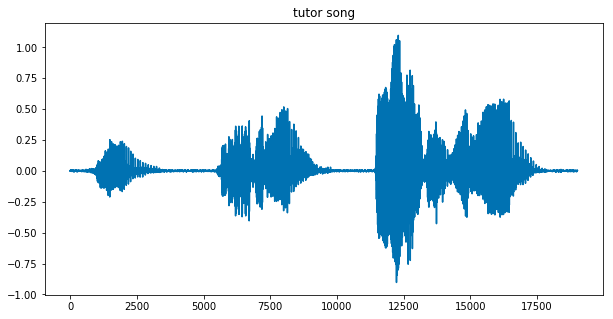

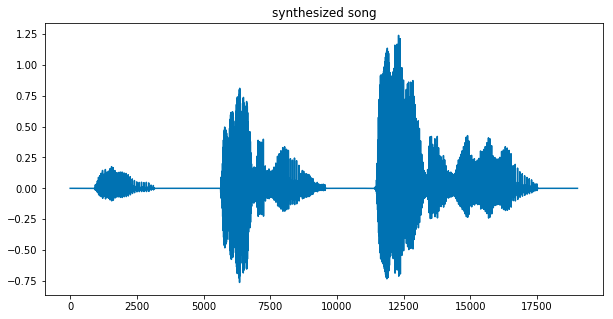

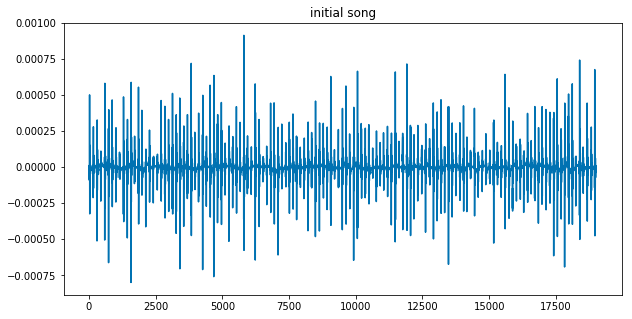

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(tutor)
plt.title("tutor song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(synth)
plt.title("synthesized song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(song)
plt.title("initial song")
plt.show()

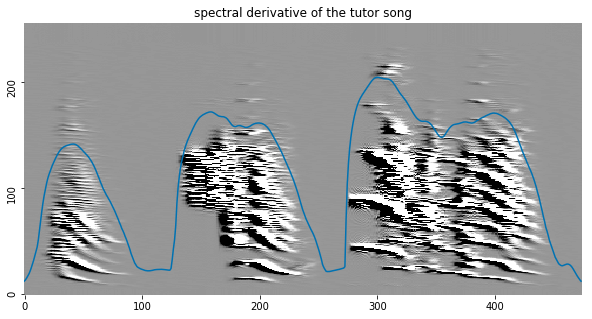

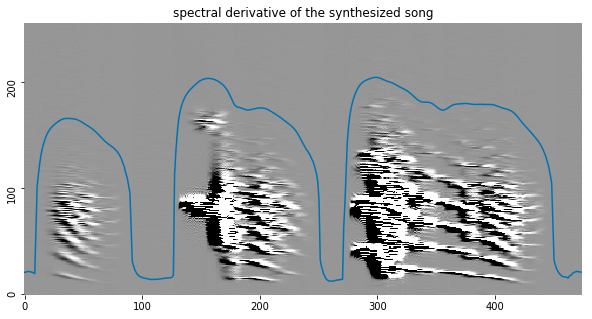

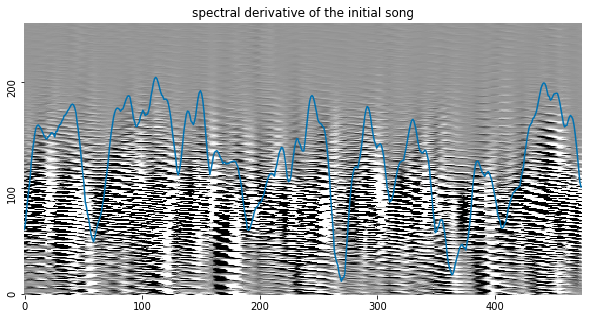

In [6]:
# Spectral derivatives
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
sspec = bsa.spectral_derivs(synth, 256, 40, 1024)
# initial song spectral derivative
ispec = bsa.spectral_derivs(song, 256, 40, 1024)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(sspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the synthesized song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(ispec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the initial song")
plt.show(fig)

# bsa_measure function step by step

# Features dict

In [7]:
tutor_feat = bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40)
synth_feat = bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40)
song_feat = bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40)

# Plots of features evolution during the song

In [8]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude']

In [ ]:
# gtes = np.loadtxt('../data/{}_gte.dat'.format(song_name))
# true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

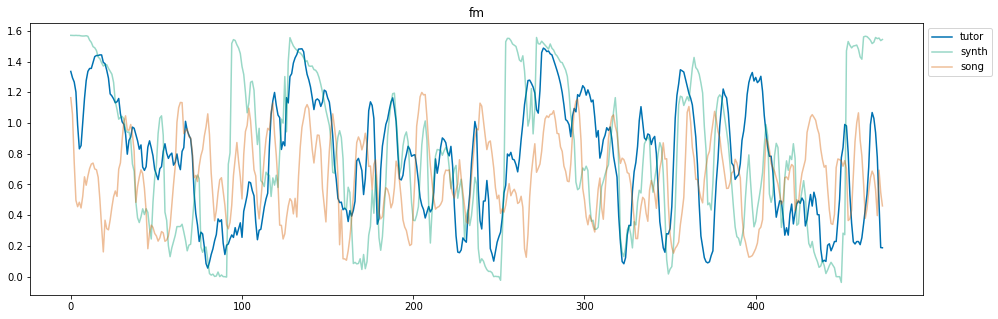

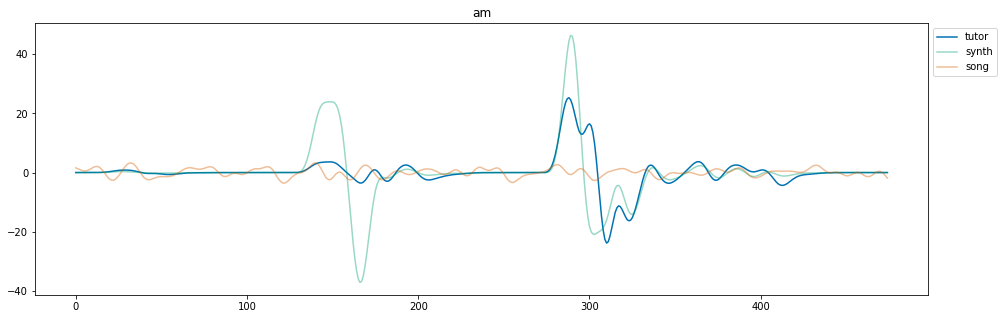

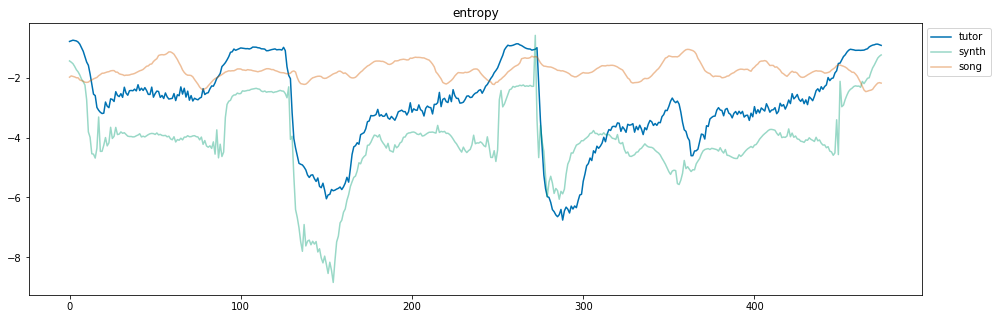

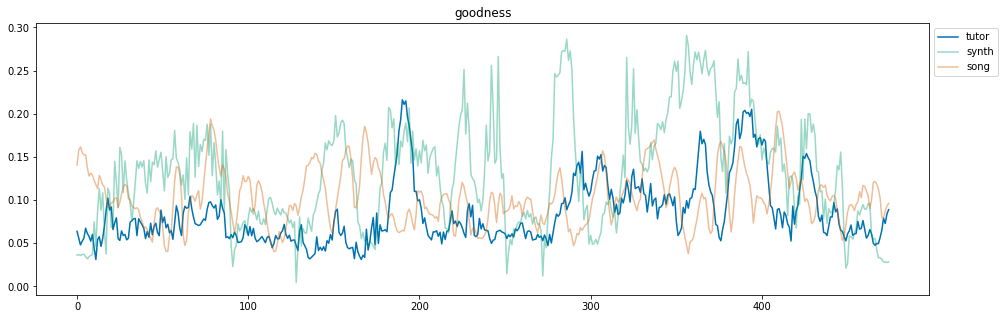

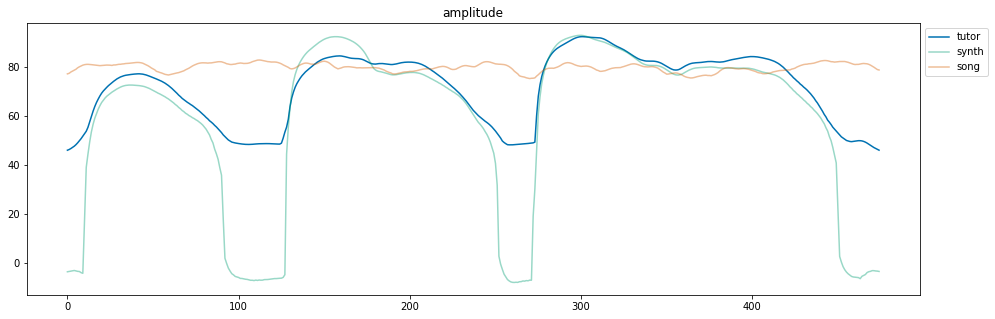

In [9]:
# fig = plt.figure(figsize=(16, 5))
# ax = fig.gca()
# ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
# bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
# for gte in true_gtes:
#     ax.axvline(x=gte/40, color="k", linewidth=1)
# plt.title("spectral derivative of the tutor song")
# plt.show(fig)

for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#     for gte in true_gtes:
#         plt.axvline(x=gte/40, color='k', linewidth=1, alpha=0.4)
plt.show()

# MAD normalization

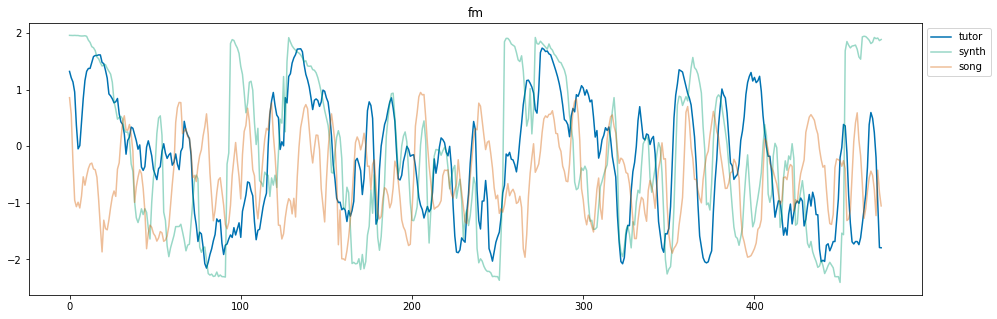

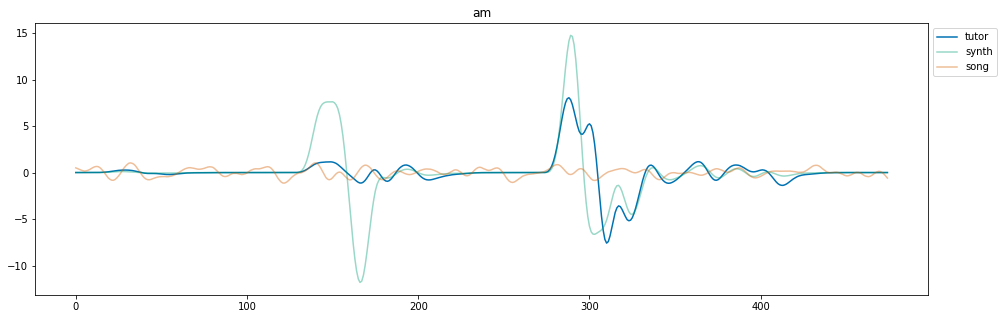

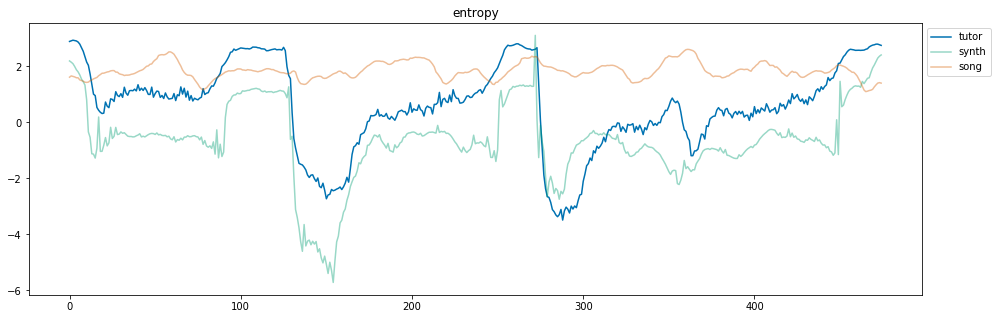

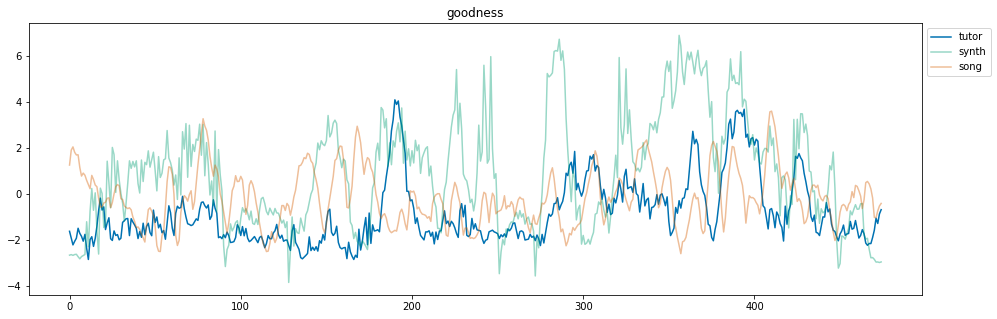

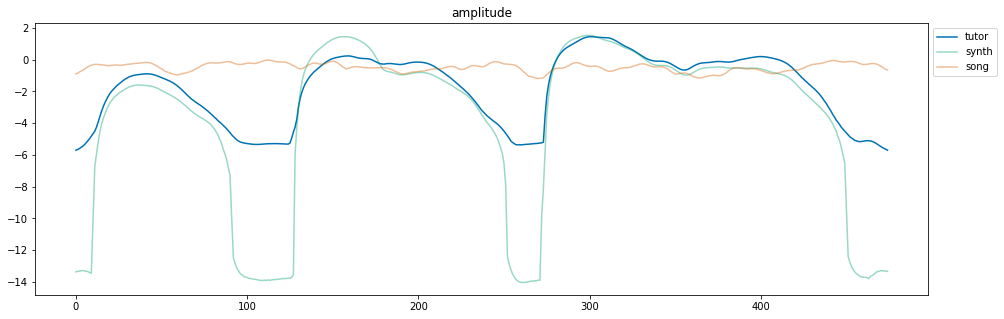

In [13]:
# MAD-NORMALIZED
tutor_feat = bsa.normalize_features(bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40))
synth_feat = bsa.normalize_features(bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40))
song_feat = bsa.normalize_features(bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40))
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# Rescaling normalization

In [20]:
p_feat = bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40)

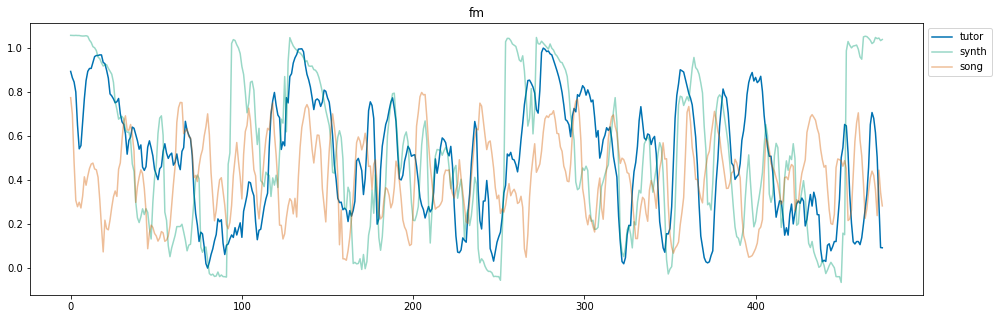

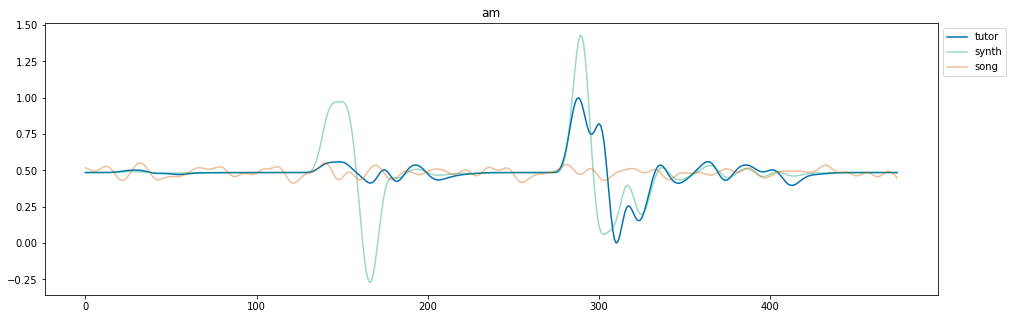

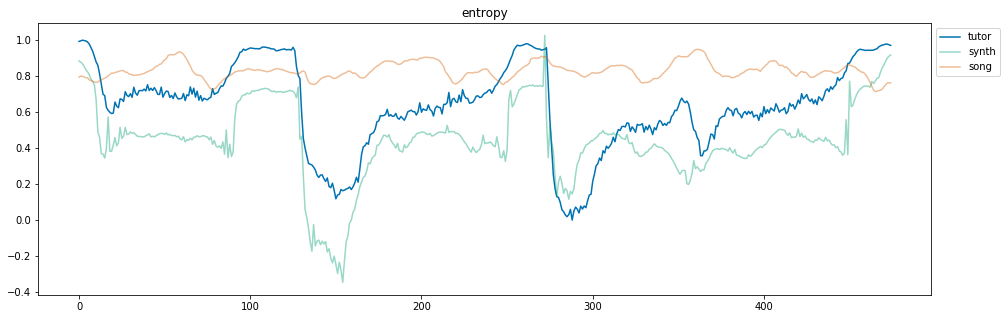

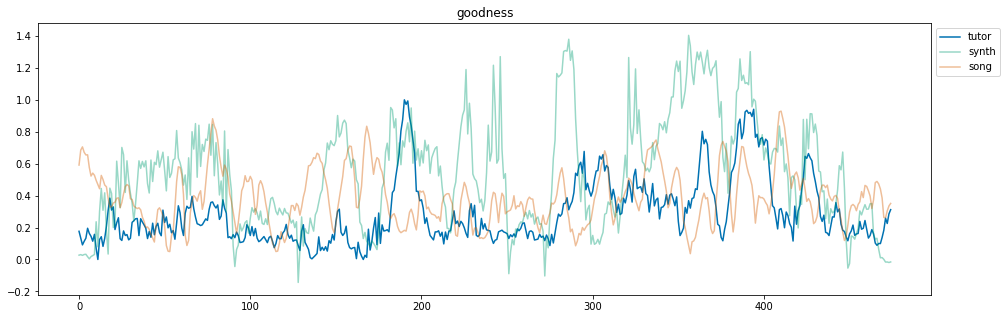

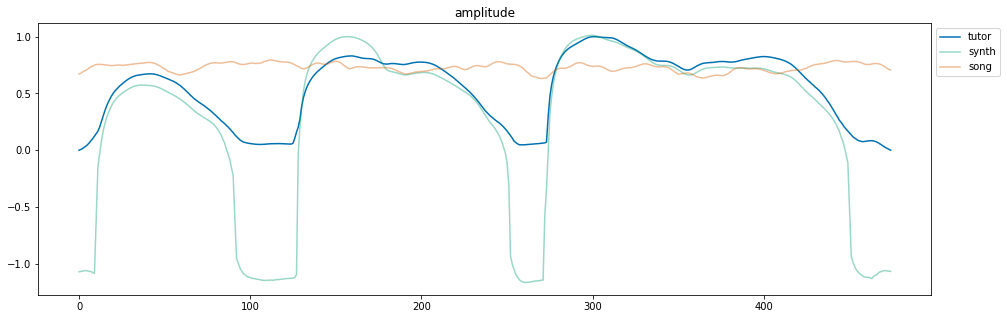

In [21]:
tutor_feat = bsa.rescaling_with_tutor_values(p_feat, 
                                             bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40))
synth_feat = bsa.rescaling_with_tutor_values(p_feat,
                                             bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40))
song_feat = bsa.rescaling_with_tutor_values(p_feat,
                                            bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40))
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# Contribution of each feature (in a vector) in the error calculation

In [22]:
# mtutor and msong are results from bsa_measure()
def err_per_feat(mtutor, msong):
    err_feats = np.zeros(mtutor.shape[1])
    for i in range(mtutor.shape[1]):
        err_feats[i] = np.sum(np.absolute(mtutor[:,i] - msong[:,i])**2)
    return err_feats

def carac_to_calculate_err_of_synth(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    return amp, threshold

# calcul a faire apres l'appel de carac_to_calculate_err_of_synth
# err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
# score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)

# Error calculations

In [33]:
coefs_list = [{"fm": 0, "am": 0, "entropy": 1, "goodness": 0, "amplitude": 1, "pitch": 0},
              {"fm": 0, "am": 0, "entropy": 5, "goodness": 0, "amplitude": 5, "pitch": 0},
              {"fm": 1, "am": 0, "entropy": 1, "goodness": 0, "amplitude": 1, "pitch": 0},
              {"fm": 5, "am": 0, "entropy": 5, "goodness": 0, "amplitude": 5, "pitch": 0},
              {"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1},
              {"fm": 1, "am": 1, "entropy": 5, "goodness": 1, "amplitude": 5, "pitch": 1},
              {"fm": 5, "am": 1, "entropy": 5, "goodness": 1, "amplitude": 5, "pitch": 1}]

In [34]:
fnames = ["fm", "am", "entropy", "goodness", "amplitude"]

for coefs in coefs_list:
    print("fm: {} / am: {} / entropy: {} / goodness: {} / amplitude: {}"
          .format(coefs["fm"], coefs["am"], coefs["entropy"], coefs["goodness"], coefs["amplitude"]))
    
    mtutor = bsa_measure(tutor, sr, coefs, tutor_feat=p_feat)
    msynth = bsa_measure(synth, sr, coefs, tutor_feat=p_feat)
    msong = bsa_measure(song, sr, coefs, tutor_feat=p_feat)
    
    err_feat_vect = err_per_feat(mtutor, msong)
    amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
    err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
    
    synth_err = utils.boari_synth_song_error(tutor, synth, coefs, tutor_feat=p_feat)
    song_err = error_measure(mtutor, msong)
    
    print("Boari err per feat:")
    str_synth = "synth: "
    str_song = "song: "
    for i in range(len(fnames)):
        str_synth += "\t{}: {}".format(fnames[i], round(err_per_feat_synth[i],3))
        str_song += "\t{}: {}".format(fnames[i], round(err_feat_vect[i],3))
    print(str_synth)
    print(str_song)
    print()
    print("Boari synth error:", synth_err)
    print("Initial song error:", song_err)
    print()
    print("Delta:", song_err - synth_err)
    print()

fm: 0 / am: 0 / entropy: 1 / goodness: 0 / amplitude: 1
Boari err per feat:
synth: 	fm: 0.0	am: 0.0	entropy: 23.064	goodness: 0.0	amplitude: 18.738
song: 	fm: 0.0	am: 0.0	entropy: 46.061	goodness: 0.0	amplitude: 63.839

Boari synth error: 7.774837306879498
Initial song error: 10.4833417775997

Delta: 2.708504470720202

fm: 0 / am: 0 / entropy: 5 / goodness: 0 / amplitude: 5
Boari err per feat:
synth: 	fm: 0.0	am: 0.0	entropy: 576.589	goodness: 0.0	amplitude: 468.443
song: 	fm: 0.0	am: 0.0	entropy: 1151.525	goodness: 0.0	amplitude: 1595.986

Boari synth error: 38.87418653439748
Initial song error: 52.416708887998496

Delta: 13.542522353601015

fm: 1 / am: 0 / entropy: 1 / goodness: 0 / amplitude: 1
Boari err per feat:
synth: 	fm: 26.535	am: 0.0	entropy: 23.064	goodness: 0.0	amplitude: 18.738
song: 	fm: 53.114	am: 0.0	entropy: 46.061	goodness: 0.0	amplitude: 63.839

Boari synth error: 9.940825291974019
Initial song error: 12.767713474003765

Delta: 2.8268881820297462

fm: 5 / am: 0 / ent